Final Project

Student name: Bikram Roy

Student pace: full time

Scheduled project review date/time:

Instructor name: Rafael Carrasco

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
import seaborn as sns
sns.set()

import time
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool, cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from geopy.geocoders import Bing
api_key = 'AuDc6-IRWQ_A3ihk6_kXHmsvgo86fec76XRDx6Gu_BoMje1Fv53_JwgASfThgu8i'
geolocator = Bing(api_key)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Reading Files

In [2]:
df = pd.read_csv('kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.000,3,1.000,1180,5650,1.000,nan,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650
1,6414100192,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639
2,5631500400,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,nan,98028,47.738,-122.233,2720,8062
3,2487200875,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000
4,1954400510,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503


## 1. Data Cleaning

In [4]:
df[df.columns].isnull().sum() # Count of Null Values in each column

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

#### 2 ways to fill missing values in `view` column.

1. Fill by mode as you can see `type 0` comes 19422 times.
2. `View` has highly correlation with `Price and waterfront`. But `waterfront` itself has large number of missing values. So using `Price` to fill the missing values.

#### 1. By mode

In [5]:
df['view'].value_counts()

0.000    19422
2.000      957
3.000      508
1.000      330
4.000      317
Name: view, dtype: int64

In [6]:
#df['view'].fillna(df['view'].mode().values[0],inplace=True) 

# Uncomment it to fill by mode.

#### 2. By Price

In [7]:
df.corr()  # Correlation

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000,-0.017,0.001,0.005,-0.012,-0.132,0.019,-0.004,0.012,-0.024,0.008,-0.011,0.022,-0.012,-0.008,-0.002,0.021,-0.003,-0.139
price,-0.017,1.000,0.309,0.526,0.702,0.090,0.257,0.276,0.396,0.036,0.668,0.605,0.054,0.130,-0.053,0.307,0.022,0.585,0.083
bedrooms,0.001,0.309,1.000,0.515,0.578,0.032,0.178,-0.002,0.079,0.026,0.357,0.479,0.156,0.018,-0.154,-0.010,0.132,0.393,0.031
bathrooms,0.005,0.526,0.515,1.000,0.756,0.088,0.503,0.067,0.186,-0.126,0.666,0.687,0.507,0.051,-0.205,0.024,0.225,0.570,0.088
sqft_living,-0.012,0.702,0.578,0.756,1.000,0.173,0.354,0.110,0.283,-0.059,0.763,0.876,0.318,0.056,-0.200,0.052,0.241,0.756,0.184
sqft_lot,-0.132,0.090,0.032,0.088,0.173,1.000,-0.005,0.023,0.075,-0.009,0.115,0.184,0.053,0.005,-0.130,-0.086,0.230,0.145,0.718
floors,0.019,0.257,0.178,0.503,0.354,-0.005,1.000,0.022,0.028,-0.264,0.459,0.524,0.489,0.004,-0.060,0.049,0.126,0.280,-0.011
waterfront,-0.004,0.276,-0.002,0.067,0.110,0.023,0.022,1.000,0.407,0.018,0.087,0.075,-0.026,0.087,0.031,-0.013,-0.040,0.089,0.032
view,0.012,0.396,0.079,0.186,0.283,0.075,0.028,0.407,1.000,0.046,0.250,0.166,-0.055,0.101,0.085,0.006,-0.078,0.280,0.073
condition,-0.024,0.036,0.026,-0.126,-0.059,-0.009,-0.264,0.018,0.046,1.000,-0.147,-0.159,-0.362,-0.062,0.003,-0.015,-0.106,-0.093,-0.003


In [8]:
df['price'].groupby([df['view']]).mean() # Mean values for different views

view
0.000    496806.066
1.000    813373.267
2.000    791390.371
3.000    973285.197
4.000   1452465.883
Name: price, dtype: float64

In [9]:
def fun_fill(price):
    '''Return type based on price'''
    if price < 496806:
        return 0
    elif price < 791390 and price >= 496806:
        return 2
    elif price < 813373 and price >= 791390:
        return 1
    elif price < 973285 and price >= 813373:
        return 2
    elif price > 973285:
        return 4

In [10]:
df['view'].loc[df['view'].isnull()] = df['price'][df['view'].isnull()].apply(fun_fill) # Filling missing values

#### Fill missing values in `waterfront` column by mode

In [11]:
df['waterfront'].value_counts()

0.000    19075
1.000      146
Name: waterfront, dtype: int64

In [12]:
df['waterfront'].fillna(df['waterfront'].mode()[0],inplace=True)

#### Fill missing values in `yr_renovated` by 0
as when the renovation not done value is 0 and if the renovation is done we don't know the exact year.

In [13]:
df['yr_renovated'].value_counts().iloc[:10] # Showing value counts for first 10

0.000       17011
2014.000       73
2003.000       31
2013.000       31
2007.000       30
2000.000       29
2005.000       29
1990.000       22
2004.000       22
2009.000       21
Name: yr_renovated, dtype: int64

In [14]:
df['yr_renovated'].fillna(0,inplace=True)

In [15]:
df[df.columns].isnull().sum() # Count of Null Values in each column

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

#### Checking Outliers in `price`

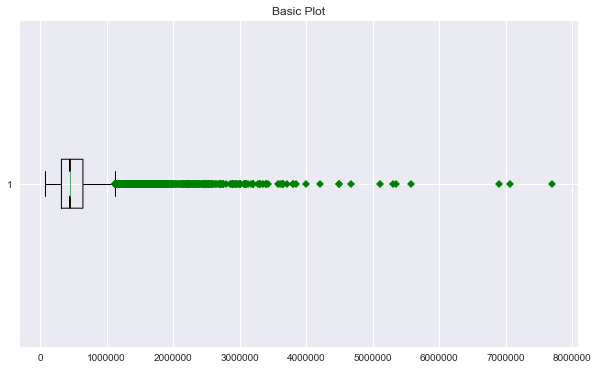

In [16]:
fig1, ax1 = plt.subplots(figsize=(10,6))
green_diamond = dict(markerfacecolor='g', marker='D')
ax1.set_title('Basic Plot')
ax1.boxplot(df['price'], notch=True, flierprops=green_diamond, vert=False)
plt.show()

#### We shouldn't remove these outliers.
As price of house could increase drastically based on locality, sqft, condition. So, we shouldn't drop or impute these outlier values.

### Get address using bing api from latitude and longitude

`Note:` Don't run these 8 cells again if you already have the Locations.csv

In [17]:
def get_address(string):
    try:
        location = geolocator.reverse(string,timeout=10)
        return location.address
    except:
        time.sleep(10)
        try:
            location = geolocator.reverse(string,timeout=10)
            return location.address
        except:
            return 'Not available'

In [18]:
df['lat'] = df['lat'].round(2) # rounding Off
df['long'] = df['long'].round(2)

In [19]:
temp = df['lat'].astype('str') + ', ' + df['long'].astype('str')

In [20]:
temp.drop_duplicates(inplace=True) # Remove duplicate values

In [21]:
temp.reset_index(drop=True,inplace=True)

result = [] #666
for i in tqdm_notebook(range(len(result),len(temp))):
    res = get_address(temp[i])
    result.append(res)

In [31]:
loc = pd.DataFrame()
loc['lat_long'] = temp
loc['address'] = result

In [27]:
loc.to_csv('Locations.csv',index=False)

#### Read address and map with coordinates

In [23]:
loc = pd.read_csv('Locations.csv')

In [24]:
df['lat'] = df['lat'].round(2) # rounding Off
df['long'] = df['long'].round(2)

In [25]:
temp = loc['lat_long'].str.split(',')
loc['lat'] = temp.str.get(0)
loc['long'] = temp.str.get(1)

In [26]:
df['lat'] = df['lat'].astype('str') 
df['long'] = df['long'].astype('str')

In [27]:
loc = loc[loc.columns[1:]]

In [28]:
loc['long'] = loc['long'].str.strip()

In [29]:
df = pd.merge(df,loc,on=['lat','long'],how='left')

#### sqft_basement have some `?`

In [30]:
df[df['sqft_basement'] == '?'].head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,address
6,1321400060,6/27/2014,257500.000,3,2.250,1715,6819,2.000,0.000,0.000,3,7,1715,?,1995,0.000,98003,47.31,-122.33,2238,6819,"330 S 327th Ln, Federal Way, WA 98003, United ..."
18,16000397,12/5/2014,189000.000,2,1.000,1200,9850,1.000,0.000,0.000,4,7,1200,?,1921,0.000,98002,47.31,-122.21,1060,5095,"201 Pike St NE, Auburn, WA 98002, United States"
42,7203220400,7/7/2014,861990.000,5,2.750,3595,5639,2.000,0.000,0.000,3,9,3595,?,2014,0.000,98053,47.68,-122.02,3625,5639,"8824 237th Pl NE, Union Hill-Novelty Hill, WA ..."
79,1531000030,3/23/2015,720000.000,4,2.500,3450,39683,2.000,0.000,0.000,3,10,3450,?,2002,0.000,98010,47.34,-122.02,3350,39750,"Green River To Cedar River Trail, Maple Valley..."
112,2525310310,9/16/2014,272500.000,3,1.750,1540,12600,1.000,0.000,0.000,4,7,1160,?,1980,0.000,98038,47.36,-122.03,1540,11656,"26914 233rd Pl SE, Maple Valley, WA 98038, Uni..."


#### Considering `?` as null and fill with `0`.

In [31]:
df['sqft_basement'] = df['sqft_basement'].str.replace('?','0')

In [32]:
df['sqft_basement'] = df['sqft_basement'].astype('float')

In [33]:
df.to_csv('clean_data.csv',index=False)

## 2. Data Exploration

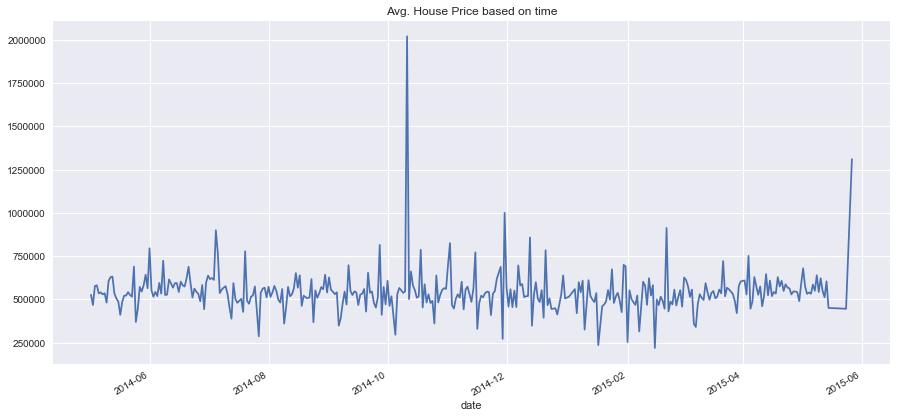

In [34]:
temp = df['price'].groupby([df['date']]).mean()
temp.index = pd.to_datetime(temp.index)
temp.plot(figsize=(15,7),title='Avg. House Price based on time')
plt.show()

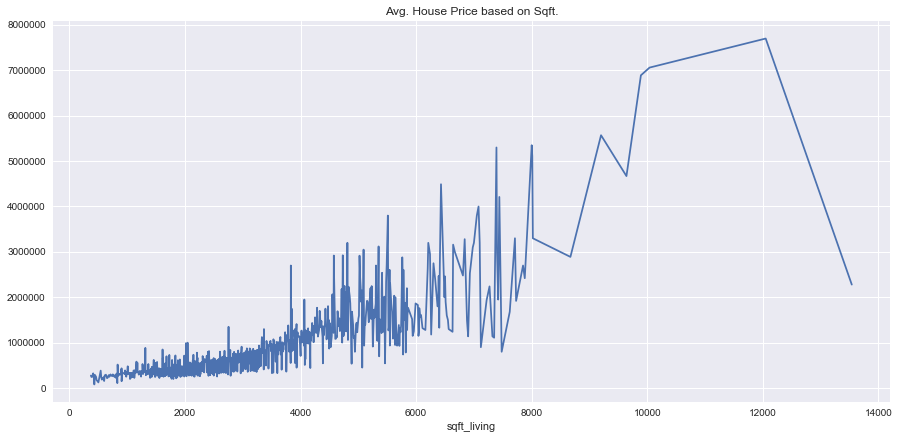

In [35]:
temp = df['price'].groupby([df['sqft_living']]).mean()
temp.plot(figsize=(15,7),title='Avg. House Price based on Sqft.')
plt.show()

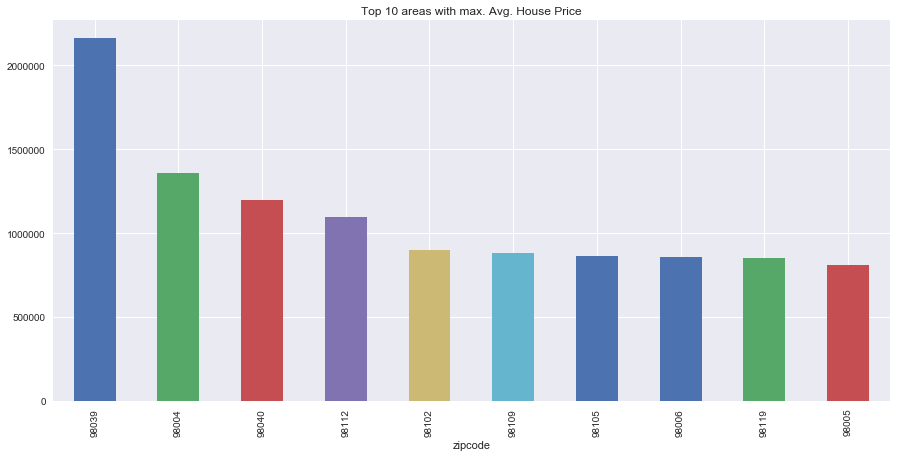

In [36]:
temp = df['price'].groupby([df['zipcode']]).mean()
temp = temp.sort_values(ascending=False)[:10]
temp.plot(kind='bar',figsize=(15,7),title='Top 10 areas with max. Avg. House Price')
plt.show()

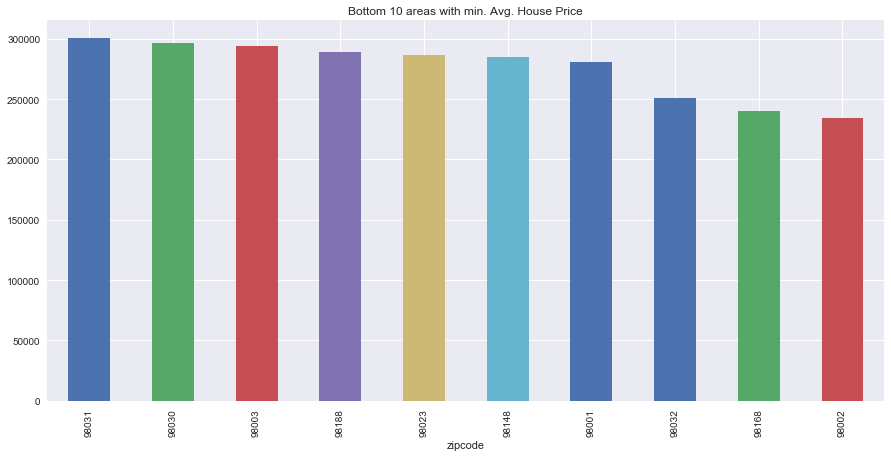

In [37]:
temp = df['price'].groupby([df['zipcode']]).mean()
temp = temp.sort_values(ascending=False)[-10:]
temp.plot(kind='bar',figsize=(15,7),title='Bottom 10 areas with min. Avg. House Price')
plt.show()

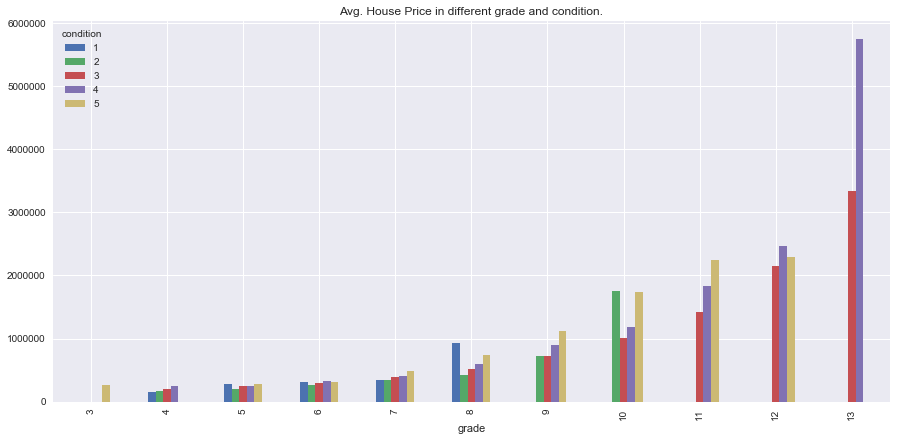

In [38]:
temp = df['price'].groupby([df['grade'], df['condition']]).mean().unstack()
temp.plot(kind='bar',figsize=(15,7),title='Avg. House Price in different grade and condition.')
plt.show()

In [39]:
df['renovated'] = np.where(df['yr_renovated'] > 0, True, False) # To find renovation has been done or not.

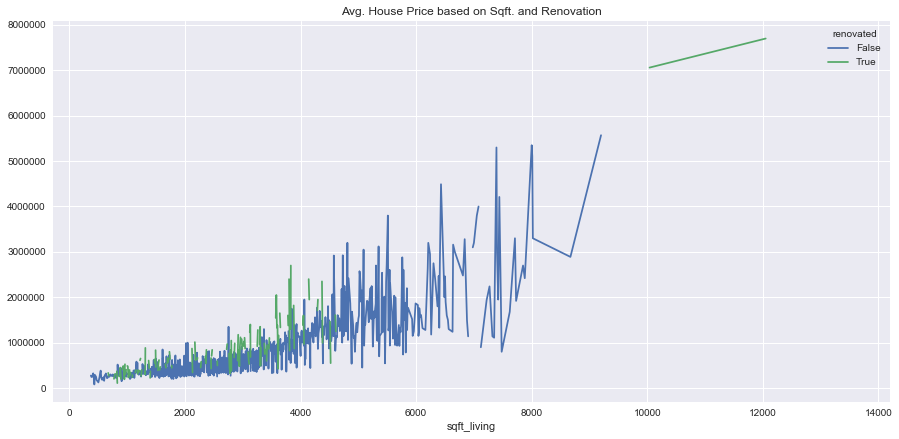

In [40]:
temp = df['price'].groupby([df['sqft_living'],df['renovated']]).mean().unstack()
temp.plot(figsize=(15,7),title='Avg. House Price based on Sqft. and Renovation')
plt.show()

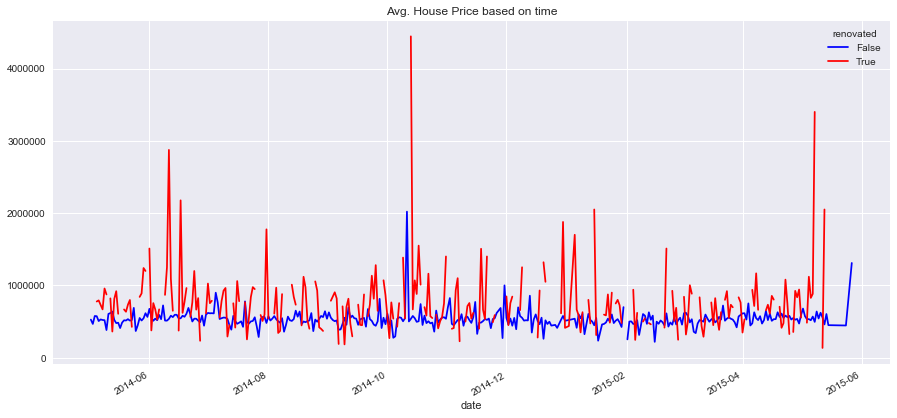

In [41]:
temp = df['price'].groupby([df['date'],df['renovated']]).mean().unstack()
temp.index = pd.to_datetime(temp.index)
temp.plot(figsize=(15,7),title='Avg. House Price based on time',color=['blue','red'])
plt.show()

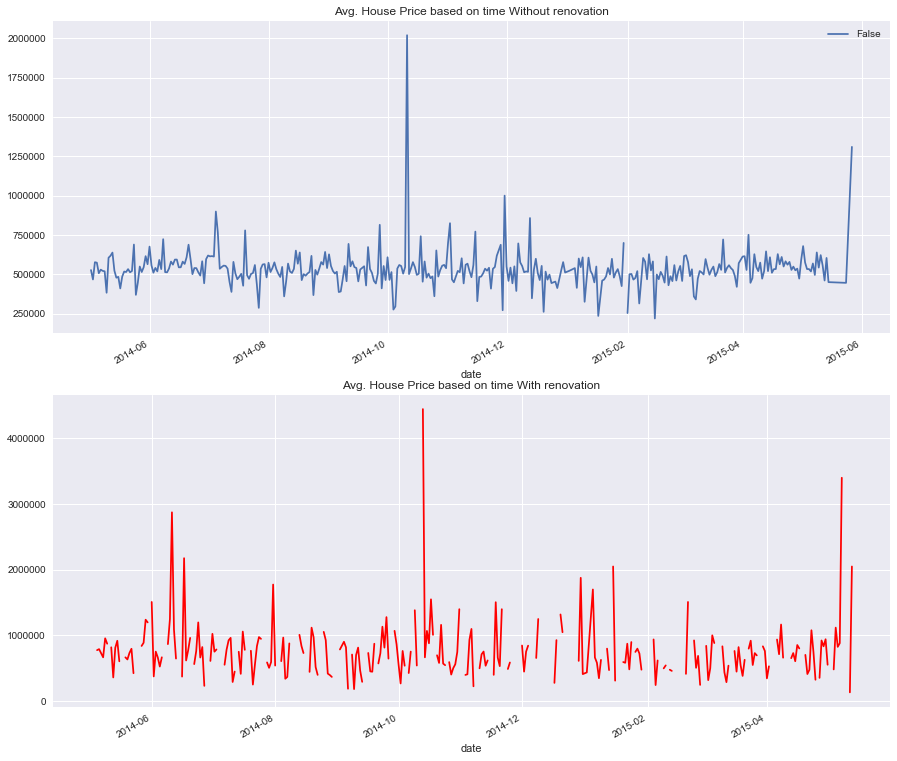

In [42]:
plt.figure(figsize=(15, 14))
plt.subplot(2, 1, 1)
temp.iloc[:,0].plot(title='Avg. House Price based on time Without renovation')
plt.legend(loc='best')
plt.subplot(2, 1, 2)
temp.iloc[:,1].plot(title='Avg. House Price based on time With renovation',color='red')
plt.show()

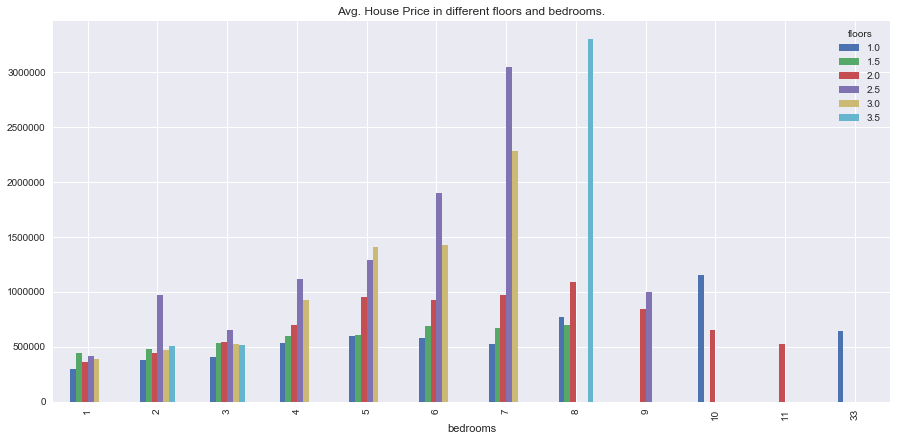

In [43]:
temp = df['price'].groupby([df['bedrooms'], df['floors']]).mean().unstack()
temp.plot(kind='bar',figsize=(15,7),title='Avg. House Price in different floors and bedrooms.')
plt.show()

In [44]:
df['bathrooms'].value_counts() # Checking different size bathrooms

2.500    5377
1.000    3851
1.750    3048
2.250    2047
2.000    1930
1.500    1445
2.750    1185
3.000     753
3.500     731
3.250     589
3.750     155
4.000     136
4.500     100
4.250      79
0.750      71
4.750      23
5.000      21
5.250      13
5.500      10
1.250       9
6.000       6
5.750       4
0.500       4
8.000       2
6.250       2
6.750       2
6.500       2
7.500       1
7.750       1
Name: bathrooms, dtype: int64

#### Here we find bathrooms are in decimals but there are many such cases where the bathrooms is in with 0.25,0.50,0.75. So, we can't  impute and change the values.

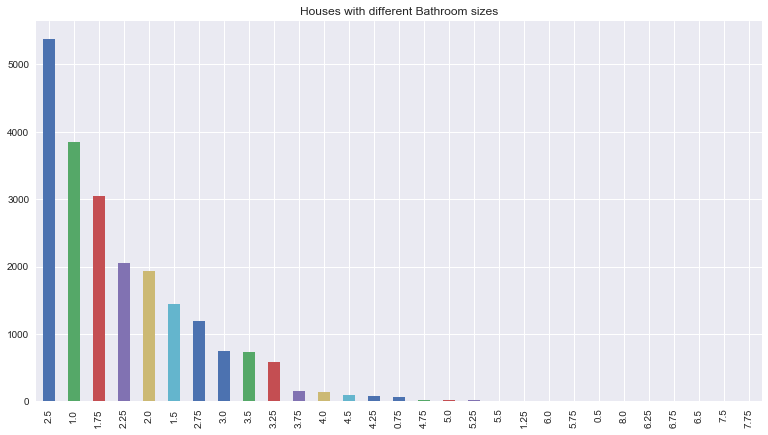

In [45]:
df['bathrooms'].value_counts().plot(kind='bar',title='Houses with different Bathroom sizes',figsize=(13,7))
plt.show()

## 3. Data Preparation for modelling

In [46]:
df['date'] = pd.to_datetime(df['date'])

df['Day'] = df['date'].dt.day.values
df['Week'] = df['date'].dt.week.values
df['WeekDay'] = df['date'].dt.weekday.values
df['month'] = df['date'].dt.month.values
df['year'] = df['date'].dt.year.values

In [48]:
df['id'].value_counts()[:10]

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
3969300030    2
2560801222    2
3883800011    2
2228900270    2
251300110     2
Name: id, dtype: int64

There are some house id's which appear more than 1 times. Still for modelling considering same id's multiple times as the price were given at different time and conditions.

In [49]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,address,renovated,Day,Week,WeekDay,month,year
0,7129300520,2014-10-13,221900.000,3,1.000,1180,5650,1.000,0.000,0.000,3,7,1180,0.000,1955,0.000,98178,47.51,-122.26,1340,5650,"5746 S Ryan St, Rainier Beach, WA 98178, Unite...",False,13,42,0,10,2014
1,6414100192,2014-12-09,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.000,1951,1991.000,98125,47.72,-122.32,1690,7639,"12526 8th Ave NE, Pinehurst, WA 98125, United ...",True,9,50,1,12,2014
2,5631500400,2015-02-25,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.000,1933,0.000,98028,47.74,-122.23,2720,8062,"8315 NE 155th St, Kenmore, WA 98028, United St...",False,25,9,2,2,2015
3,2487200875,2014-12-09,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.000,1965,0.000,98136,47.52,-122.39,1360,5000,"4419 SW Brace Point Dr, Fauntleroy, WA 98136, ...",False,9,50,1,12,2014
4,1954400510,2015-02-18,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.000,1987,0.000,98074,47.62,-122.04,1800,7503,"22460 NE 10th St, Sammamish, WA 98074, United ...",False,18,8,2,2,2015


#### Finding house locality

Full address fetched from bing can be break into 4 types.

In [50]:
temp = df['address'].str.split(',')
df['locality_1'] = temp.str.get(-4)
df['locality_2'] = temp.str.get(-3)
df['locality_3'] = temp.str.get(-2)
df['locality_4'] = temp.str.get(-1)

#### check top 10 locality of each type

In [48]:
df['locality_1'].value_counts()[:10]

I-90 E                   90
2425 NE Larchmount St    83
3710 SW Southern St      75
137 25th Ave E           73
7019 26th Ave NW         70
702 N 97th St            70
7008 3rd Ave NW          68
826 25th Ave             65
7011 18th Ave NW         65
3743 Belvidere Ave SW    64
Name: locality_1, dtype: int64

In [49]:
df['locality_2'].value_counts()[:10]

 Renton                     1026
 Sammamish                   932
 Federal Way                 665
 Kent                        625
 Shoreline                   557
 Maple Valley                526
 Union Hill-Novelty Hill     404
 Auburn                      399
 Highline                    366
 East Hill-Meridian          351
Name: locality_2, dtype: int64

In [50]:
df['locality_3'].value_counts()[:10]

 WA 98117    629
 WA 98103    618
 WA 98052    583
 WA 98034    556
 WA 98042    556
 WA 98038    554
 WA 98115    547
 WA 98126    515
 WA 98059    477
 WA 98023    472
Name: locality_3, dtype: int64

In [51]:
df['locality_4'].value_counts()[:10]

 United States    21597
Name: locality_4, dtype: int64

Here as we can see in last type only one country `United States` is present. So, this column didn't give us anything meaningful in modelling.

`Locality_3` is also same as `zipcode`. So may not consider any one column in features.

#### Selecting the features.

In [52]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade',
           'sqft_above','sqft_basement','yr_built','yr_renovated','zipcode','sqft_living15','sqft_lot15',
          'renovated','Day','Week','WeekDay','month','year','locality_1','locality_2']

In [53]:
df['renovated'] = df['renovated'].astype('int') # Changing bool type to int

In [54]:
df['locality_1'].fillna('',inplace=True)
df['locality_2'].fillna('',inplace=True)

#### Using `Label Encoder` to encode locality column class values to integer

In [55]:
le = preprocessing.LabelEncoder()

In [56]:
le.fit(df['locality_1'])
df['locality_1'] = le.transform(df['locality_1'])

In [57]:
le.fit(df['locality_2'])
df['locality_2'] = le.transform(df['locality_2'])

#### `Classes` in each column

In [58]:
df[features].nunique()

bedrooms           12
bathrooms          29
sqft_living      1034
sqft_lot         9776
floors              6
waterfront          2
view                5
condition           5
grade              11
sqft_above        942
sqft_basement     303
yr_built          116
yr_renovated       70
zipcode            70
sqft_living15     777
sqft_lot15       8682
renovated           2
Day                31
Week               52
WeekDay             7
month              12
year                2
locality_1       1884
locality_2        212
dtype: int64

## 4. Modelling 

### Checking cross validation on Random Forest.

In [61]:
model = RandomForestRegressor(max_depth=6, random_state=0,n_jobs=-1,
                             n_estimators=100)

results = cross_val_score(model, df[features], df['price'], cv=3, n_jobs=-1,scoring='mean_squared_error')

#### Scores(RMSE) in each fold.

In [62]:
np.sqrt(-results).tolist()

[197081.31489784172, 188161.47458932866, 201429.77488234517]

In [63]:
np.sqrt(-results).mean()  # Average

195557.52145650517

Avg. **RMSE** error from Random Forest.

Text(0,0.5,'Feature Importance Score')

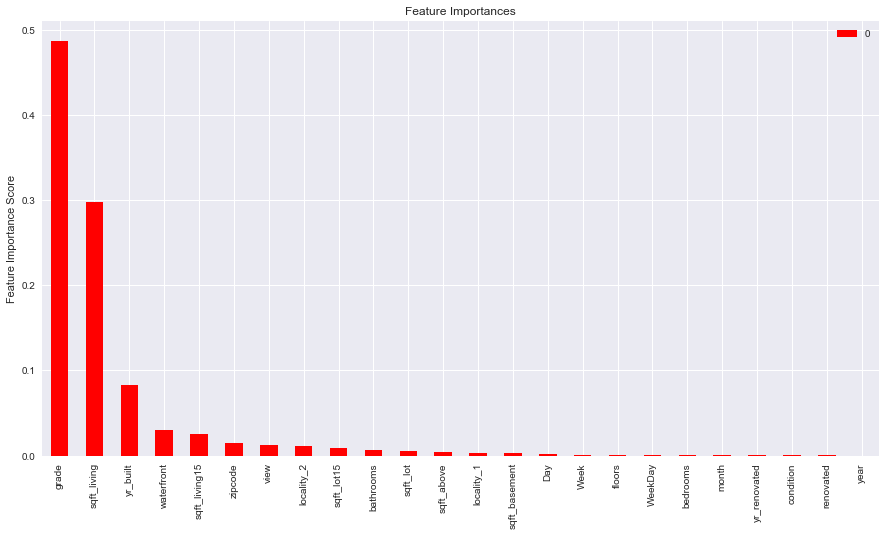

In [64]:
model.fit(df[features],df['price'])
feature = pd.DataFrame(model.feature_importances_,features)
feature = feature.sort_values(by=0,ascending=False)

feature.plot(kind='bar', title='Feature Importances',figsize=(15,8),color='red')
plt.ylabel('Feature Importance Score By Random Forest')

### Checking cross validation on Xgboost.

In [67]:
model = XGBRegressor(max_depth=6, random_state=0,n_jobs=-1,
                             n_estimators=100)
results = cross_val_score(model, df[features], df['price'], cv=3, n_jobs=-1,scoring='mean_squared_error')

#### Scores(RMSE) in each fold.

In [68]:
np.sqrt(-results).tolist()

[144586.97291371762, 142203.88186014266, 150204.79558287642]

In [69]:
np.sqrt(-results).mean()  # Average

145665.2167855789

#### Avg. RMSE error from Xgboost.

Text(0,0.5,'Feature Importance Score By Xgboost')

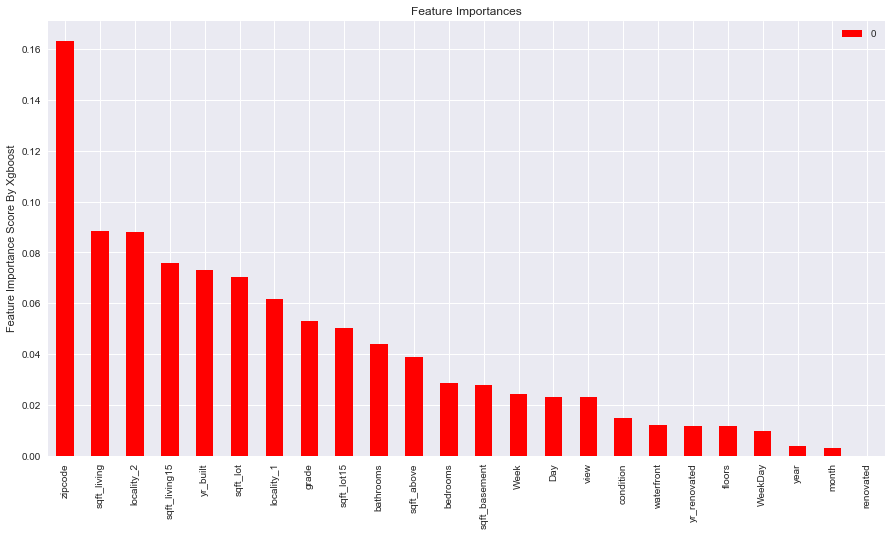

In [70]:
model.fit(df[features],df['price'])
feature = pd.DataFrame(model.feature_importances_,features)
feature = feature.sort_values(by=0,ascending=False)

feature.plot(kind='bar', title='Feature Importances',figsize=(15,8),color='red')
plt.ylabel('Feature Importance Score By Xgboost')

### Parameter Tuning on Xgboost Model. 

In [113]:
%%time

params = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators' : [100,500],
    'max_depth' : [3,4,5],
    'n_jobs' : [-1]
}
gs = GridSearchCV(model, params, cv=5, n_jobs=-1,scoring='mean_squared_error')
gs.fit(df[features],df['price'])

Wall time: 3min 32s


In [114]:
res_df = pd.DataFrame()
for i in range(len(gs.grid_scores_)):
    temp = pd.DataFrame()
    temp['mean'] = list([gs.grid_scores_[i][1]])
    temp['learning_rate'] = list([gs.grid_scores_[i][0]['learning_rate']])
    temp['max_depth'] = list([gs.grid_scores_[i][0]['max_depth']])
    temp['n_estimators'] = list([gs.grid_scores_[i][0]['n_estimators']])
    res_df = pd.concat([res_df,temp])

In [115]:
res_df['mean'] = res_df['mean'] * -1
res_df['mean'] = np.sqrt(res_df['mean'])
res_df = res_df.sort_values(by='mean')
res_df

,mean,learning_rate,max_depth,n_estimators
0,125683.968,0.200,4,500
0,127346.563,0.200,5,500
0,127464.607,0.100,5,500
0,128269.821,0.200,3,500
0,128402.392,0.100,4,500
0,129112.890,0.050,5,500
0,132729.183,0.100,3,500
0,133032.299,0.050,4,500
0,133254.806,0.200,5,100
0,137831.497,0.200,4,100


### Checking Cross-fold on parameter tuned model.

In [117]:
model = XGBRegressor(max_depth=4, random_state=0,n_jobs=-1,learning_rate=0.2,
                             n_estimators=500)
results = cross_val_score(model, df[features], df['price'], cv=3, n_jobs=-1,scoring='mean_squared_error')

#### Scores(RMSE) in each fold.

In [118]:
np.sqrt(-results).tolist()

[132091.3665708369, 124356.59335775704, 135269.60054681185]

In [119]:
np.sqrt(-results).mean()

130572.52015846859

#### Avg. RMSE error from parameter tuned Xgboost

### Checking cross validation on Catboost

In [133]:
df['bathrooms'] = df['bathrooms'].astype('str')
df['yr_renovated'] = df['yr_renovated'].astype('str')
df['floors'] = df['floors'].astype('str')

In [138]:
model = CatBoostRegressor(random_state=0,thread_count=12)
cv_params = model.get_params()

cv_data = cv(
    Pool(df[features], df['price'], cat_features=[0,1,4,5,6,7,8,11,12,13,16,17,18,19,20,21,22,23]),
    cv_params,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [139]:
print('Best validation RMSE score: {:.2f}±{:.2f} on step {}'.format(
    np.min(cv_data['test-RMSE-mean']),
    cv_data['test-RMSE-std'][np.argmin(cv_data['test-RMSE-mean'])],
    np.argmin(cv_data['test-RMSE-mean'])
))

Best validation RMSE score: 137176.95±10949.67 on step 999


## 5. Choosing best model and splitting data

#### Selecting Best Model:

* Random Forest on Cross-Validation RMSE Score is: 195557.52
* XgBoost on Cross-Validation RMSE Score is      : 130572.52
* CatBoost on Cross-Validation RMSE Score is     : 137176.95

Our best Model is Parametric tuned Xgboost.

### Split in Train and Test and Predict

In [59]:
df['bathrooms'] = df['bathrooms'].astype('float')
df['yr_renovated'] = df['yr_renovated'].astype('float')
df['floors'] = df['floors'].astype('float')

In [66]:
x_train,x_test,y_train,y_test =  train_test_split(df[features], df['price'],test_size=0.2,random_state = 0)

In [67]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((17277, 24), (4320, 24), (17277,), (4320,))

In [68]:
model = XGBRegressor(max_depth=4, random_state=0,n_jobs=-1,learning_rate=0.2,
                             n_estimators=500)
model.fit(x_train,y_train)
pred = model.predict(x_test)

In [69]:
res = metrics.mean_squared_error(y_test,pred)
res = np.sqrt(res)
print('RMSE Score: ', res)

RMSE Score:  111705.45461172788


In [72]:
print('R-squared Error: ', metrics.r2_score(y_test,pred))

R-squared Error:  0.8939995272832442
